/tmp/ipykernel_14002/3947726027.py:68: DeprecationWarning: XML_Node::build: 
The CTI and XML input file formats are deprecated and will be removed in
Cantera 3.0. Use 'cti2yaml.py' or 'ctml2yaml.py' to convert CTI or XML input
files to the YAML format. See https://cantera.org/tutorials/legacy2yaml.html
for more information.
  gas = ct.Solution(reaction_mechanism)


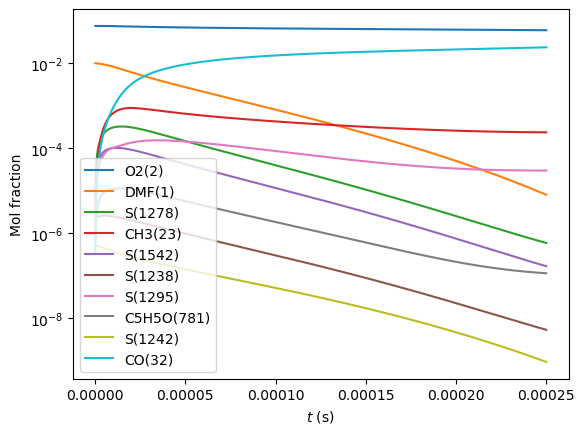

In [1]:
# Simulate species concentrations in a plug flow reactor (PFR).

#if you dont have conda enviroment- write in terminal:
# conda create --name ct-env --channel cantera cantera ipython matplotlib jupyter
# conda activate ct-env

import cantera as ct
import numpy as np
import matplotlib.pyplot as plt


# -----------------
# User input:

T_0 = 1500.0  # Inlet temperature, Kelvin

pressure = ct.one_atm  # constant pressure, Pa

# input file containing the reaction mechanism
reaction_mechanism = 'data/dmf.cti'

# Define the components and concentrations. The names must match to thoes in your model:
composition = {'DMF(1)': 0.01, 'O2(2)': 0.075, 'Ar': 0.915}

length = 1.5e-6  # *approximate* PFR length, m
u_0 = .006  # inflow velocity, m/s
area = 1.e-4  # cross-sectional area, m^2

# Give a name for the output figure. Define as None to supress saving the figure:
figure_name = 'PFR_1.jpg'

# The number of species to plot (top species concentrations):
top_num = 10

# Whther to make the Y axis in log scale
semi_log_y = True

# Resolution: The PFR will be simulated by 'n_steps' time steps or by a chain of 'n_steps' stirred reactors.
n_steps = 2000

# Paste here (between the opening and closing """   """ marks the list of species from your Cantera file)
species = """     Ar          Ne          DMF(1)      O2(2)
                     H(3)        H2(4)       OH(5)       O(6)
                     H2O(7)      HO2(8)      VA(13)      C4H3(17)
                     hcccch(19)  hcch(20)    C2H4(22)    CH3(23)
                     HCO(24)     CH3CO(25)   C2H3(27)    CH2O(29)
                     CH2CO(30)   CO(32)      C2H6(51)    C2H5(52)
                     HCCO(65)    CHCHO(70)   C2H(72)     C3H3(74)
                     C3H5(103)   C3H6(104)   C4H5(115)   C4H5(116)
                     C5H6(119)   C5H7(312)   C5H5O(324)  C5H5O(335)
                     C5H7(338)   C5H5O(781)  C4H5(782)   S(1229)
                     S(1230)     S(1232)     S(1238)     S(1240)
                     S(1242)     S(1248)     S(1259)     S(1265)
                     S(1276)     S(1278)     S(1295)     S(1378)
                     S(1384)     S(1407)     S(1542)     S(1777)
                     S(1819)     S(1820)     S(1941)     C4H5(1950)
                     C4H5(1952)  S(2376)     S(2441)     S(2446)
                     S(4561)     S(4611)     S(4619)     S(4651)
                     S(5057)     S(10821)    S(11900)    S(11908)
                     """


# End of user input
# -----------------



# Load the model:
gas = ct.Solution(reaction_mechanism)
# import the gas model and set the initial conditions
gas1 = ct.Solution(reaction_mechanism)
gas1.TPX = T_0, pressure, composition
mass_flow_rate1 = u_0 * gas1.density * area

# create a new reactor
r1 = ct.IdealGasConstPressureReactor(gas1)
# create a reactor network for performing time integration
sim1 = ct.ReactorNet([r1])

# approximate a time step to achieve a similar resolution as in the next method
t_total = length / u_0
dt = t_total / n_steps
# define time, space, and other information vectors
t1 = (np.arange(n_steps) + 1) * dt
z1 = np.zeros_like(t1)
u1 = np.zeros_like(t1)
states1 = ct.SolutionArray(r1.thermo)
for n1, t_i in enumerate(t1):
    # perform time integration
    sim1.advance(t_i)
    # compute velocity and transform into space
    u1[n1] = mass_flow_rate1 / area / r1.thermo.density
    z1[n1] = z1[n1 - 1] + u1[n1] * dt
    states1.append(r1.thermo.state)


species = species.split()

top_species  =list()
max_dict = dict()

for label in species:
    if 'Ar' not in label:
        max_dict[label] = states1.X[:, gas1.species_index(label)]

sorted_max_list = [k for k, v in sorted(max_dict.items(), key=lambda item: item[1][0], reverse=True)]


plt.figure()
for i in range(top_num):
    if semi_log_y:
        plt.semilogy(t1, states1.X[:, gas1.species_index(sorted_max_list[i])], label=sorted_max_list[i].split('()')[0])
    else:
        plt.plot(t1, states1.X[:, gas1.species_index(sorted_max_list[i])], label=sorted_max_list[i].split('()')[0])
plt.xlabel('$t$ (s)')
plt.ylabel('Mol fraction')
plt.legend(loc=0)

if figure_name:
    plt.savefig(figure_name, dpi=300, format='jpg')

ax = plt.gca()
plt.show()
